In [64]:
import os
import sys
import random
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import sumolib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import sys
import io
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import pandas as pd


if 'SUMO_HOME' in os.environ:
    print('SUMO_HOME found')
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import traci
from sumolib import checkBinary
# sumoBinary = checkBinary('sumo-gui')
sumoBinary = checkBinary('sumo')
roadNetwork = "./config/osm.sumocfg"
sumoCmd = [sumoBinary, "-c", roadNetwork, "--start", "--quit-on-end"]
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

SUMO_HOME found
Using device: cuda


## Check if there are parallel edges (multigrpah)

In [65]:
net = sumolib.net.readNet('./config/osm.net.xml.gz')

# Extract nodes and edges
nodes = net.getNodes()
edges = net.getEdges()

edges_from_to = {}
for edge in edges:
    from_node = edge.getFromNode().getID()
    to_node = edge.getToNode().getID()
    if (from_node, to_node) not in edges_from_to:
        edges_from_to[(from_node, to_node)] = [edge]
    else:
        edges_from_to[(from_node, to_node)].append(edge)

for from_node, to_node in edges_from_to.keys():
    if len(edges_from_to[(from_node, to_node)]) > 1:
        print(from_node, to_node)
        for edge in edges_from_to[(from_node, to_node)]:
            print(edge.getID())
            num_lanes = edge.getLaneNumber()
            speed_limit = edge.getSpeed()
            length = edge.getLength()

In [66]:
def randomTrips(dur=10000, density=12):
    os.system("python $SUMO_HOME/tools/randomTrips.py -n config/osm.net.xml.gz -r config/osm.passenger.trips.xml -e " + str(dur) + " -l --insertion-density=" + str(density))

def shouldContinueSim():
    numVehicles = traci.simulation.getMinExpectedNumber()
    return True if numVehicles > 0 else False

def restart(dur, density):
    with io.StringIO() as buf, redirect_stdout(buf):
        try:
            traci.close()
        except:
            pass
        randomTrips(dur, density)
        traci.start(sumoCmd)
        step = 0
        for i in range(100):
            traci.simulationStep()
            step += 1

In [68]:
def get_trajectories(dur=10000, density=12):
    randomTrips(dur, density)
    trajectories = {}
    traci.start(sumoCmd)
    while shouldContinueSim():
        traci.simulationStep()
        for vehicle in traci.vehicle.getIDList():
            if vehicle not in trajectories:
                trajectories[vehicle] = []
            x, y = traci.vehicle.getPosition(vehicle)
            speed = traci.vehicle.getSpeed(vehicle)
            direction = np.deg2rad(traci.vehicle.getAngle(vehicle))
            velocity_x = speed * np.sin(direction)
            velocity_y = speed * np.cos(direction)
            trajectories[vehicle] += [x, y, velocity_x, velocity_y]
    traci.close()
    return trajectories
trajectories = get_trajectories()

Success.
 Retrying in 1 seconds
***Starting server on port 42591 ***
Loading net-file from './config/osm.net.xml.gz' ... done (65ms).
Loading additional-files from './config/osm.poly.xml.gz' ... done (160ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Simulation ended at time: 10476.00
Reason: TraCI requested termination.
Performance: 
 Duration: 17.60s
 TraCI-Duration: 16.09s
 Real time factor: 595.363
 UPS: 18326.210502
Vehicles: 
 Inserted: 1530
 Running: 0
 Waiting: 0
Statistics (avg of 1530):
 RouteLength: 1611.54
 Speed: 7.66
 Duration: 210.76
 WaitingTime: 12.69
 TimeLoss: 40.04
 DepartDelay: 0.55



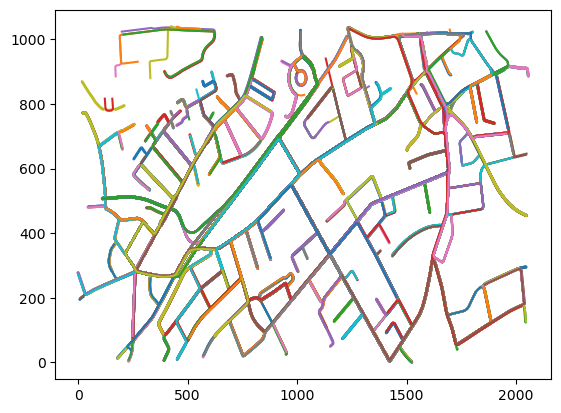

In [70]:
# plot the first 10 trajectories
def plot_trajectories(trajectories, n=10):
    for i, vehicle in enumerate(trajectories.keys()):
        if i > n:
            break
        trajectory = trajectories[vehicle]
        x = trajectory[::4]
        y = trajectory[1::4]
        plt.plot(x, y)
    plt.show()
plot_trajectories(trajectories, 1000)

In [84]:
# pad trajectories to have the same length
def pad_trajectories(trajectories):
    max_len = 0
    for vehicle in trajectories.keys():
        max_len = max(max_len, len(trajectories[vehicle]))
    for vehicle in trajectories.keys():
        trajectories[vehicle] += [0] * (max_len - len(trajectories[vehicle]))
    return trajectories

trajectories = pad_trajectories(trajectories)
df = pd.DataFrame(list(trajectories.values()), index=trajectories.keys())
print(df.head())
df.to_csv('edinburgh_trajectories.csv')

          0           1     2     3            4           5         6     \
0  1849.654504  604.681999  -0.0  -0.0  1848.072338  603.315860 -1.632102   
1  1603.065374  468.388027  -0.0   0.0  1602.570941  470.303508 -0.494444   
2   965.439044  182.387393  -0.0  -0.0   964.319345  181.479241 -1.119699   
3   533.438054  644.566185  -0.0   0.0   532.482345  646.868918 -0.979153   
4  1107.693730  619.970881   0.0  -0.0  1108.907826  618.397511  1.125442   

       7            8           9     ...  2370  2371  2372  2373  2374  2375  \
0 -1.317525  1845.580177  600.564949  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1  1.915525  1601.654258  473.854829  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2 -0.908152   961.899707  179.516749  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3  2.292392   530.812299  650.892808  ...   0.0   0.0   0.0   0.0   0.0   0.0   
4 -1.637854  1111.370436  615.947398  ...   0.0   0.0   0.0   0.0   0.0   0.0   

   2376  2377  2378  2379  
0   0.0   0.0   0.0   